# Langaus
Convoluted Landau and Gaussian Fitting Function
        (using ROOT's Landau and Gauss functions)

 Based on a Fortran code by R.Fruehwirth (fruhwirth@hephy.oeaw.ac.at)

 to execute this example, do:

```cpp
 root > .x langaus.C
```

or

```cpp
 root > .x langaus.C++
```




**Author:**  H.Pernegger, Markus Friedl  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 01:30 AM.</small></i>

In [1]:
%%cpp -d
#include "TH1.h"
#include "TF1.h"
#include "TROOT.h"
#include "TStyle.h"
#include "TMath.h"

 A helper function is created: 

In [2]:
%%cpp -d
Double_t langaufun(Double_t *x, Double_t *par) {

   //Fit parameters:
   //par[0]=Width (scale) parameter of Landau density
   //par[1]=Most Probable (MP, location) parameter of Landau density
   //par[2]=Total area (integral -inf to inf, normalization constant)
   //par[3]=Width (sigma) of convoluted Gaussian function
   //
   //In the Landau distribution (represented by the CERNLIB approximation),
   //the maximum is located at x=-0.22278298 with the location parameter=0.
   //This shift is corrected within this function, so that the actual
   //maximum is identical to the MP parameter.

      // Numeric constants
      Double_t invsq2pi = 0.3989422804014;   // (2 pi)^(-1/2)
      Double_t mpshift  = -0.22278298;       // Landau maximum location

      // Control constants
      Double_t np = 100.0;      // number of convolution steps
      Double_t sc =   5.0;      // convolution extends to +-sc Gaussian sigmas

      // Variables
      Double_t xx;
      Double_t mpc;
      Double_t fland;
      Double_t sum = 0.0;
      Double_t xlow,xupp;
      Double_t step;
      Double_t i;


      // MP shift correction
      mpc = par[1] - mpshift * par[0];

      // Range of convolution integral
      xlow = x[0] - sc * par[3];
      xupp = x[0] + sc * par[3];

      step = (xupp-xlow) / np;

      // Convolution integral of Landau and Gaussian by sum
      for(i=1.0; i<=np/2; i++) {
         xx = xlow + (i-.5) * step;
         fland = TMath::Landau(xx,mpc,par[0]) / par[0];
         sum += fland * TMath::Gaus(x[0],xx,par[3]);

         xx = xupp - (i-.5) * step;
         fland = TMath::Landau(xx,mpc,par[0]) / par[0];
         sum += fland * TMath::Gaus(x[0],xx,par[3]);
      }

      return (par[2] * step * sum * invsq2pi / par[3]);
}

 A helper function is created: 

In [3]:
%%cpp -d
TF1 *langaufit(TH1F *his, Double_t *fitrange, Double_t *startvalues, Double_t *parlimitslo, Double_t *parlimitshi, Double_t *fitparams, Double_t *fiterrors, Double_t *ChiSqr, Int_t *NDF)
{
   // Once again, here are the Landau * Gaussian parameters:
   //   par[0]=Width (scale) parameter of Landau density
   //   par[1]=Most Probable (MP, location) parameter of Landau density
   //   par[2]=Total area (integral -inf to inf, normalization constant)
   //   par[3]=Width (sigma) of convoluted Gaussian function
   //
   // Variables for langaufit call:
   //   his             histogram to fit
   //   fitrange[2]     lo and hi boundaries of fit range
   //   startvalues[4]  reasonable start values for the fit
   //   parlimitslo[4]  lower parameter limits
   //   parlimitshi[4]  upper parameter limits
   //   fitparams[4]    returns the final fit parameters
   //   fiterrors[4]    returns the final fit errors
   //   ChiSqr          returns the chi square
   //   NDF             returns ndf

   Int_t i;
   Char_t FunName[100];

   sprintf(FunName,"Fitfcn_%s",his->GetName());

   TF1 *ffitold = (TF1*)gROOT->GetListOfFunctions()->FindObject(FunName);
   if (ffitold) delete ffitold;

   TF1 *ffit = new TF1(FunName,langaufun,fitrange[0],fitrange[1],4);
   ffit->SetParameters(startvalues);
   ffit->SetParNames("Width","MP","Area","GSigma");

   for (i=0; i<4; i++) {
      ffit->SetParLimits(i, parlimitslo[i], parlimitshi[i]);
   }

   his->Fit(FunName,"RB0");   // fit within specified range, use ParLimits, do not plot

   ffit->GetParameters(fitparams);    // obtain fit parameters
   for (i=0; i<4; i++) {
      fiterrors[i] = ffit->GetParError(i);     // obtain fit parameter errors
   }
   ChiSqr[0] = ffit->GetChisquare();  // obtain chi^2
   NDF[0] = ffit->GetNDF();           // obtain ndf

   return (ffit);              // return fit function

}

 A helper function is created: 

In [4]:
%%cpp -d
Int_t langaupro(Double_t *params, Double_t &maxx, Double_t &FWHM) {

   // Seaches for the location (x value) at the maximum of the
   // Landau-Gaussian convolute and its full width at half-maximum.
   //
   // The search is probably not very efficient, but it's a first try.

   Double_t p,x,fy,fxr,fxl;
   Double_t step;
   Double_t l,lold;
   Int_t i = 0;
   Int_t MAXCALLS = 10000;


   // Search for maximum

   p = params[1] - 0.1 * params[0];
   step = 0.05 * params[0];
   lold = -2.0;
   l    = -1.0;


   while ( (l != lold) && (i < MAXCALLS) ) {
      i++;

      lold = l;
      x = p + step;
      l = langaufun(&x,params);

      if (l < lold)
         step = -step/10;

      p += step;
   }

   if (i == MAXCALLS)
      return (-1);

   maxx = x;

   fy = l/2;


   // Search for right x location of fy

   p = maxx + params[0];
   step = params[0];
   lold = -2.0;
   l    = -1e300;
   i    = 0;


   while ( (l != lold) && (i < MAXCALLS) ) {
      i++;

      lold = l;
      x = p + step;
      l = TMath::Abs(langaufun(&x,params) - fy);

      if (l > lold)
         step = -step/10;

      p += step;
   }

   if (i == MAXCALLS)
      return (-2);

   fxr = x;


   // Search for left x location of fy

   p = maxx - 0.5 * params[0];
   step = -params[0];
   lold = -2.0;
   l    = -1e300;
   i    = 0;

   while ( (l != lold) && (i < MAXCALLS) ) {
      i++;

      lold = l;
      x = p + step;
      l = TMath::Abs(langaufun(&x,params) - fy);

      if (l > lold)
         step = -step/10;

      p += step;
   }

   if (i == MAXCALLS)
      return (-3);


   fxl = x;

   FWHM = fxr - fxl;
   return (0);
}

Fill histogram

In [5]:
Int_t data[100] = {0,0,0,0,0,0,2,6,11,18,18,55,90,141,255,323,454,563,681,
                 737,821,796,832,720,637,558,519,460,357,291,279,241,212,
                 153,164,139,106,95,91,76,80,80,59,58,51,30,49,23,35,28,23,
                 22,27,27,24,20,16,17,14,20,12,12,13,10,17,7,6,12,6,12,4,
                 9,9,10,3,4,5,2,4,1,5,5,1,7,1,6,3,3,3,4,5,4,4,2,2,7,2,4};
TH1F *hSNR = new TH1F("snr","Signal-to-noise",400,0,400);

for (Int_t i=0; i<100; i++) hSNR->Fill(i,data[i]);

Fitting snr histo

In [6]:
printf("Fitting...\n");

Fitting...


Setting fit range and start values

In [7]:
Double_t fr[2];
Double_t sv[4], pllo[4], plhi[4], fp[4], fpe[4];
fr[0]=0.3*hSNR->GetMean();
fr[1]=3.0*hSNR->GetMean();

pllo[0]=0.5; pllo[1]=5.0; pllo[2]=1.0; pllo[3]=0.4;
plhi[0]=5.0; plhi[1]=50.0; plhi[2]=1000000.0; plhi[3]=5.0;
sv[0]=1.8; sv[1]=20.0; sv[2]=50000.0; sv[3]=3.0;

Double_t chisqr;
Int_t    ndf;
TF1 *fitsnr = langaufit(hSNR,fr,sv,pllo,plhi,fp,fpe,&chisqr,&ndf);

Double_t SNRPeak, SNRFWHM;
langaupro(fp,SNRPeak,SNRFWHM);

printf("Fitting done\nPlotting results...\n");

 FCN=5.25252 FROM MIGRAD    STATUS=CONVERGED     193 CALLS         194 TOTAL
                     EDM=3.227e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Width        1.25740e+00   3.04846e-01   1.37307e-04   1.57021e-04
   2  MP           2.08890e+01   1.28244e+00   3.40886e-05   8.22843e-04
   3  Area         1.15515e+04   2.42312e+03   1.66644e-05  -1.66635e-03
   4  GSigma       4.06350e+00   7.58845e-01   2.30703e-04  -2.48397e-04
Fitting done
Plotting results...


Global style settings

In [8]:
gStyle->SetOptStat(1111);
gStyle->SetOptFit(111);
gStyle->SetLabelSize(0.03,"x");
gStyle->SetLabelSize(0.03,"y");

hSNR->GetXaxis()->SetRange(0,70);
hSNR->Draw();
fitsnr->Draw("lsame");

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Draw all canvases 

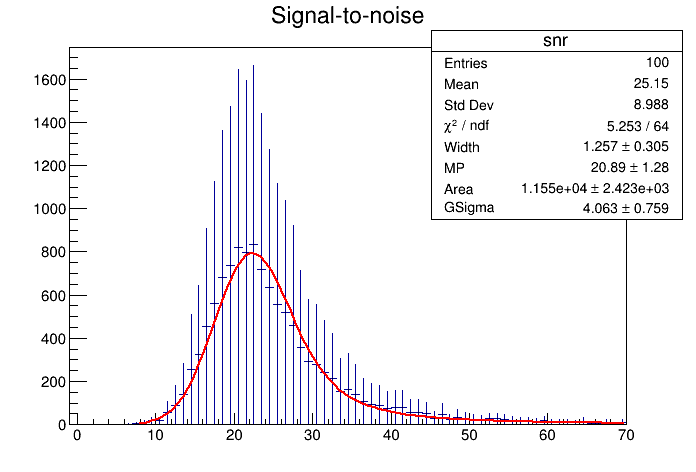

In [9]:
gROOT->GetListOfCanvases()->Draw()